<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
from matplotlib.patches import Polygon
from matplotlib import animation
import seaborn as sns
import scipy as sp
from scipy import signal
from scipy.interpolate import griddata
from datetime import timedelta, datetime
from IPython.display import HTML

In [4]:
def mask_outside_polygon(poly_verts, ax=None):
    """
    Plots a mask on the specified axis ("ax", defaults to plt.gca()) such that
    all areas outside of the polygon specified by "poly_verts" are masked.  

    "poly_verts" must be a list of tuples of the verticies in the polygon in
    counter-clockwise order.

    Returns the matplotlib.patches.PathPatch instance plotted on the figure.
    """
    import matplotlib.patches as mpatches
    import matplotlib.path as mpath

    if ax is None:
        ax = plt.gca()

    # Get current plot limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Verticies of the plot boundaries in clockwise order
    bound_verts = [(xlim[0], ylim[0]), (xlim[0], ylim[1]), 
                   (xlim[1], ylim[1]), (xlim[1], ylim[0]), 
                   (xlim[0], ylim[0])]

    # A series of codes (1 and 2) to tell matplotlib whether to draw a line or 
    # move the "pen" (So that there's no connecting line)
    bound_codes = [mpath.Path.MOVETO] + (len(bound_verts) - 1) * [mpath.Path.LINETO]
    poly_codes = [mpath.Path.MOVETO] + (len(poly_verts) - 1) * [mpath.Path.LINETO]

    # Plot the masking patch
    path = mpath.Path(bound_verts + poly_verts, bound_codes + poly_codes)
    patch = mpatches.PathPatch(path, facecolor='white', edgecolor='none')
    patch = ax.add_patch(patch)

    # Reset the plot limits to their original extents
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    return patch

# Importing Data

## Importing Hourly Resolution Data

### Obtaining Longitudes and Latitudes from All Stations

We start by reading the first two lines of the data file to obtain the longitude and latitude information of the stations. We zip them together into a list of tuples, and add an element to the beginning of this list corresponding to the time.

In [5]:
lon_and_lat = np.genfromtxt('AllStations_temperature_h_2017.dat', delimiter=" ", max_rows=2)
longitudes = lon_and_lat[0][~np.isnan(lon_and_lat[0])]
latitudes = lon_and_lat[1][~np.isnan(lon_and_lat[1])]

indices = list(zip(longitudes, latitudes))
indices.insert(0, "time")

In [6]:
longitudes

array([236.554, 236.499, 236.679, 236.607, 236.514, 236.63 , 236.523,
       236.543, 236.662, 236.304, 236.604, 236.43 , 236.7  , 236.471,
       236.446, 236.25 , 236.283, 236.597, 236.635, 236.494, 236.672,
       236.639, 236.595, 236.67 , 236.686, 236.579, 236.639, 236.641,
       236.619, 236.514, 236.357, 236.574, 236.596, 236.676, 236.691,
       236.689, 236.451])

### Reading the Temperature Data

We now read in the temperature data, skipping the first two rows that contain the longitude and latitude information of the stations. The column names of the dataframe are the longitude and latitude tuples created above, and the index column is the timestamps.

In [7]:
df = pd.read_csv('AllStations_temperature_h_2017.dat', sep='\s+', skiprows=[0,1], names=indices, index_col = 'time')
df.head()

,236.554,236.499,236.679,236.607,236.514,236.630,236.523,236.543,236.662,236.304,...,236.641,236.619,236.514,236.357,236.574,236.596,236.676,236.691,236.689,236.451
,48.5745,48.5376,48.4655,48.4608,48.4356,48.5273,48.4529,48.6804,48.4562,48.3891,...,48.4683,48.4744,48.4205,48.6568,48.4533,48.6529,48.4865,48.4623,48.4359,48.4572
time,,,,,,,,,,,,,,,,,,,,,
733408.0000,3.25,1.43,4.21,4.62,3.45,4.44,2.72,3.97,4.68,5.12,...,4.29,4.10,3.01,NaN,4.00,4.81,4.58,NaN,4.87,4.07
733408.0417,3.06,1.38,4.28,4.77,3.46,4.21,2.64,4.15,4.61,4.95,...,4.41,4.30,2.87,NaN,4.15,4.60,4.44,NaN,4.85,4.05
733408.0833,1.90,1.18,4.12,4.70,3.46,4.07,2.64,4.18,4.62,5.11,...,4.24,4.23,2.97,NaN,4.06,4.65,4.47,NaN,4.91,4.02
733408.1250,1.69,0.98,4.20,4.77,3.65,3.67,2.81,4.27,4.71,5.33,...,4.36,4.30,3.10,NaN,4.12,4.75,4.53,NaN,4.97,4.06
733408.1667,2.09,0.93,4.61,4.99,3.90,3.55,3.11,4.29,4.93,5.56,...,4.58,4.53,3.37,NaN,4.25,4.97,4.68,NaN,5.17,4.27


### Changing the Datetimes into Appropriate Timestamps

The Datetimes used in this file are MATLAB datetimes. We use a function to convert each time in the time column to the appropriate timestamp and then change the index column into timestamps.

In [8]:
def matlab_to_python_datetime(matlab_datenum):
    return datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366)

df.index = [matlab_to_python_datetime(i) for i in df.index]
df.head()

,236.554,236.499,236.679,236.607,236.514,236.630,236.523,236.543,236.662,236.304,...,236.641,236.619,236.514,236.357,236.574,236.596,236.676,236.691,236.689,236.451
,48.5745,48.5376,48.4655,48.4608,48.4356,48.5273,48.4529,48.6804,48.4562,48.3891,...,48.4683,48.4744,48.4205,48.6568,48.4533,48.6529,48.4865,48.4623,48.4359,48.4572
2008-01-01 00:00:00.000000,3.25,1.43,4.21,4.62,3.45,4.44,2.72,3.97,4.68,5.12,...,4.29,4.10,3.01,NaN,4.00,4.81,4.58,NaN,4.87,4.07
2008-01-01 01:00:02.879995,3.06,1.38,4.28,4.77,3.46,4.21,2.64,4.15,4.61,4.95,...,4.41,4.30,2.87,NaN,4.15,4.60,4.44,NaN,4.85,4.05
2008-01-01 01:59:57.120005,1.90,1.18,4.12,4.70,3.46,4.07,2.64,4.18,4.62,5.11,...,4.24,4.23,2.97,NaN,4.06,4.65,4.47,NaN,4.91,4.02
2008-01-01 03:00:00.000000,1.69,0.98,4.20,4.77,3.65,3.67,2.81,4.27,4.71,5.33,...,4.36,4.30,3.10,NaN,4.12,4.75,4.53,NaN,4.97,4.06
2008-01-01 04:00:02.879995,2.09,0.93,4.61,4.99,3.90,3.55,3.11,4.29,4.93,5.56,...,4.58,4.53,3.37,NaN,4.25,4.97,4.68,NaN,5.17,4.27


### Obtain Winter and Summer Data

In [9]:
winter_start = pd.Timestamp(year=2016, month=12, day=1, hour=0)
winter_end = pd.Timestamp(year=2017, month=3, day=1, hour=0)
summer_start = pd.Timestamp(year=2017, month=6, day=1, hour=0)
summer_end = pd.Timestamp(year=2017, month=9, day=1, hour=0)

winter_data = df[(df.index>winter_start) & (df.index<winter_end)]
summer_data = df[(df.index>summer_start) & (df.index<summer_end)]

In [10]:
winter_data

,236.554,236.499,236.679,236.607,236.514,236.630,236.523,236.543,236.662,236.304,...,236.641,236.619,236.514,236.357,236.574,236.596,236.676,236.691,236.689,236.451
,48.5745,48.5376,48.4655,48.4608,48.4356,48.5273,48.4529,48.6804,48.4562,48.3891,...,48.4683,48.4744,48.4205,48.6568,48.4533,48.6529,48.4865,48.4623,48.4359,48.4572
2016-12-01 01:00:02.879995,1.17,NaN,2.13,0.74,1.96,3.34,2.22,3.58,2.44,2.14,...,1.58,2.07,3.66,1.80,1.76,3.61,3.62,5.99,3.01,1.69
2016-12-01 01:59:57.120005,1.03,NaN,1.51,0.20,1.56,3.13,1.41,3.21,1.74,1.95,...,0.92,1.69,2.59,1.58,1.16,3.21,3.06,5.63,2.36,1.17
2016-12-01 03:00:00.000000,1.64,NaN,1.21,-0.15,1.24,3.03,1.19,3.01,1.55,1.44,...,0.59,1.05,2.06,1.22,0.82,2.99,3.59,6.02,1.85,0.74
2016-12-01 04:00:02.879995,1.19,NaN,1.20,-0.31,1.00,2.62,1.35,3.30,1.24,1.25,...,0.44,0.61,2.04,0.89,0.61,2.55,3.47,5.30,1.38,0.96
2016-12-01 04:59:57.120005,1.03,NaN,0.97,-0.63,0.85,2.28,1.02,3.06,1.21,1.30,...,-0.04,0.33,2.12,0.99,0.40,2.64,4.03,5.29,0.98,0.81
2016-12-01 06:00:00.000000,1.04,NaN,0.64,-0.79,0.99,2.07,0.77,2.82,1.16,1.22,...,-0.16,0.54,1.81,0.53,0.23,2.29,2.92,4.78,0.41,0.62
2016-12-01 07:00:02.879995,1.14,NaN,0.47,-0.83,0.65,NaN,0.73,2.72,0.91,1.37,...,-0.30,0.51,2.17,0.23,0.16,2.38,2.41,4.97,0.46,0.62
2016-12-01 07:59:57.120005,1.59,NaN,0.74,-0.35,0.47,2.42,0.98,2.78,1.38,1.81,...,0.19,0.29,2.67,0.49,0.51,2.64,3.21,5.01,0.70,1.20
2016-12-01 09:00:00.000000,2.53,NaN,2.87,1.47,2.03,4.23,2.42,3.23,4.30,2.86,...,2.36,1.73,4.14,1.54,2.06,3.53,4.89,5.63,2.97,2.38


## Look at Missing Data

**Winter Data**

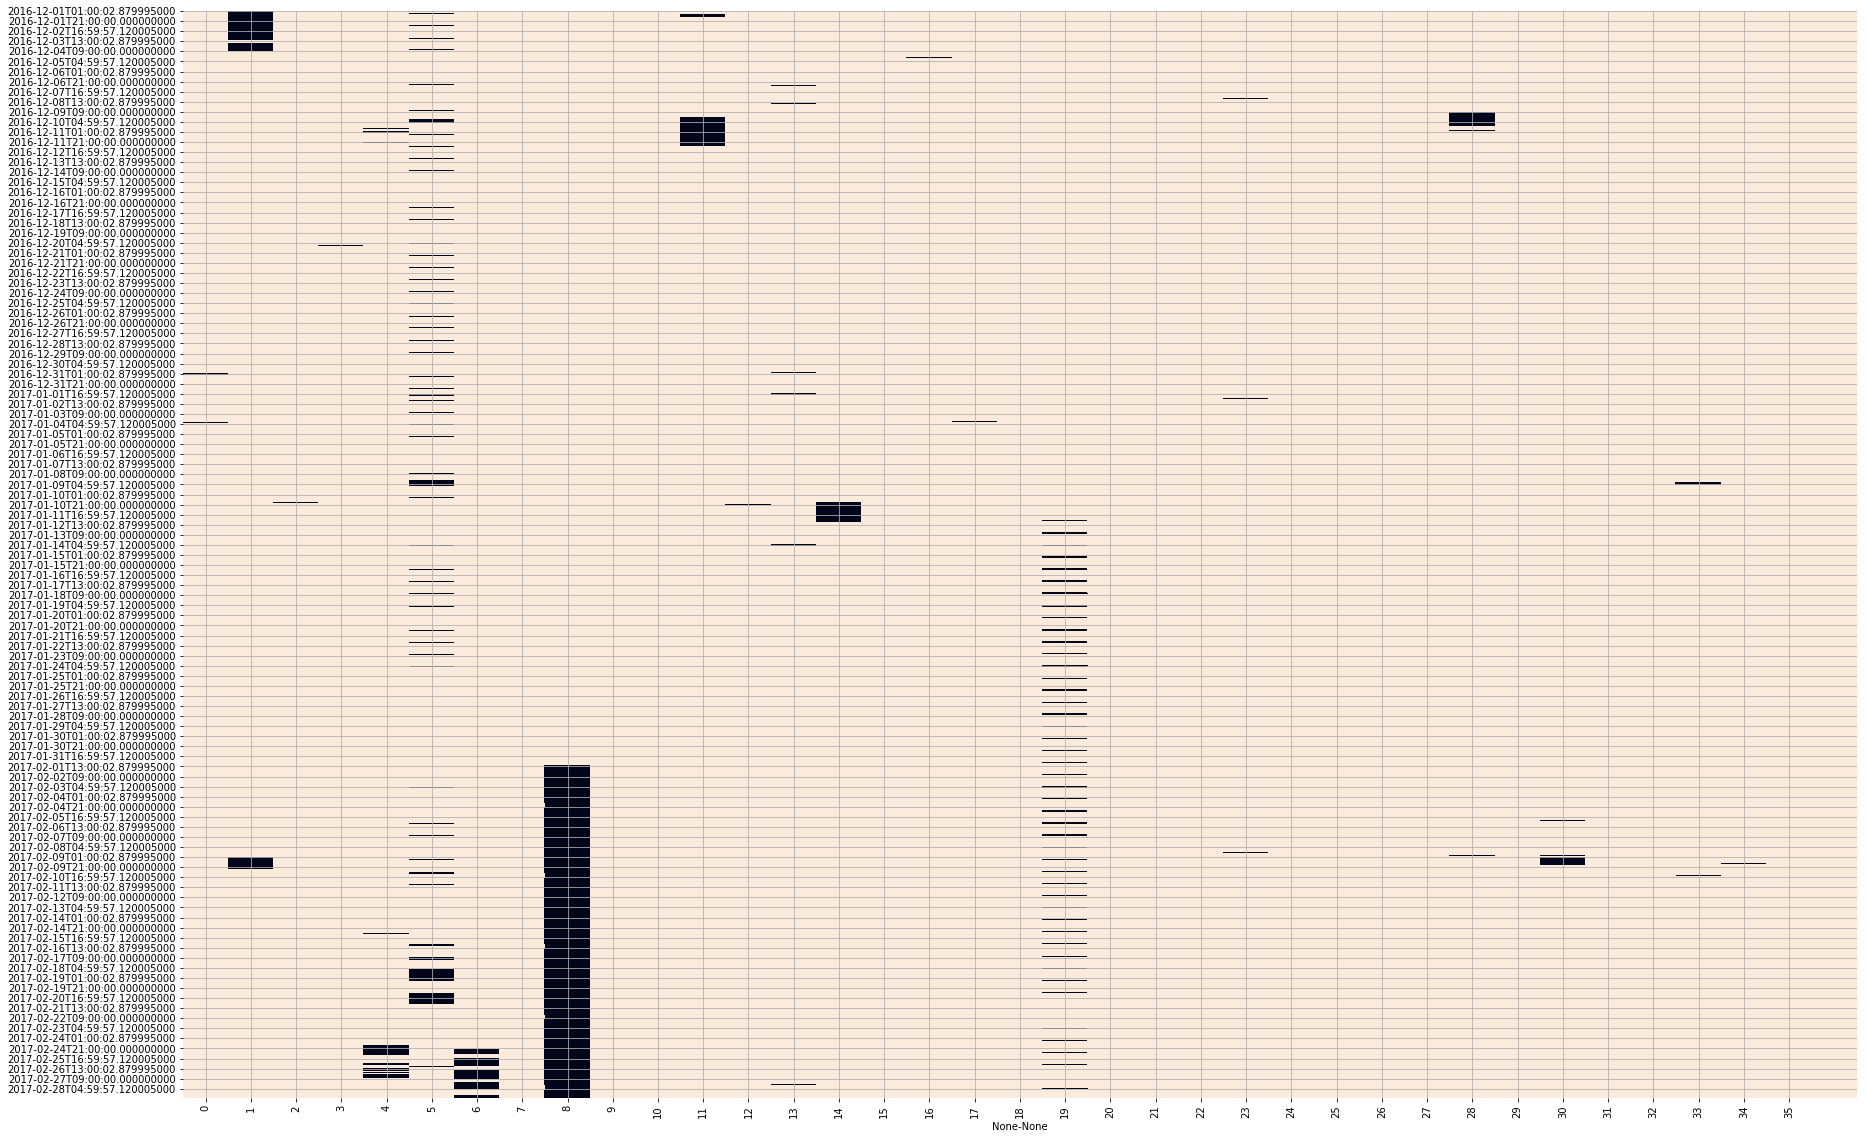

In [11]:
fig, ax = plt.subplots(figsize=(30, 20))

sns.heatmap(~winter_data.isnull(), cbar=False, ax=ax)
ax.grid()
plt.xticks(np.arange(36)+0.5, np.arange(0, 36, 1))

plt.show()

**Summer Data**

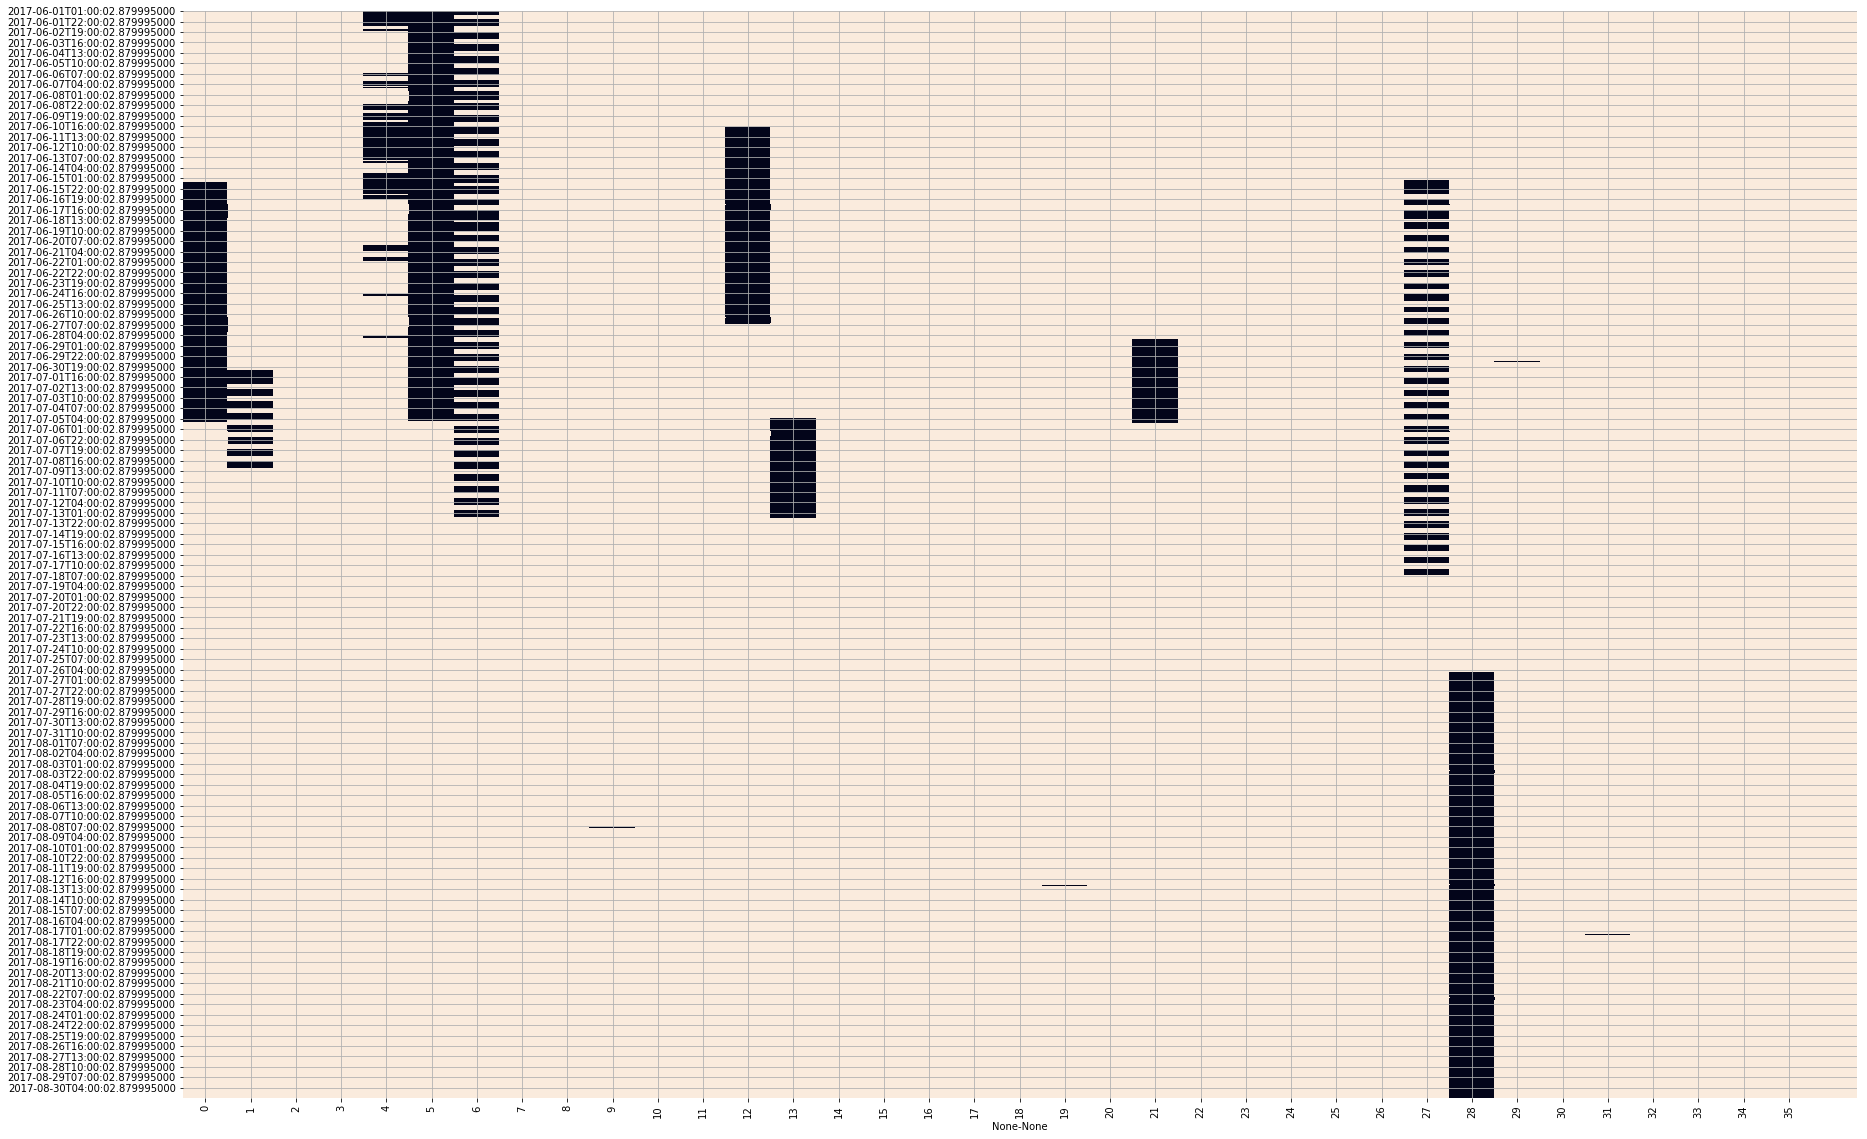

In [12]:
fig, ax = plt.subplots(figsize=(30, 20))

sns.heatmap(~summer_data.isnull(), cbar=False, ax=ax)
ax.grid()
plt.xticks(np.arange(36)+0.5, np.arange(0, 36, 1))

plt.show()

## Remove the Stations with Lots of Missing Data and Interpolate the Others

In [13]:
winter_removed = [1, 6, 8, 11, 14]
summer_removed = [0, 4, 5, 6, 12, 13, 21, 27, 28]

winter_filt = winter_data.drop(winter_data.columns[winter_removed],axis=1)
summer_filt = summer_data.drop(summer_data.columns[summer_removed],axis=1)

Plot the new missing data.

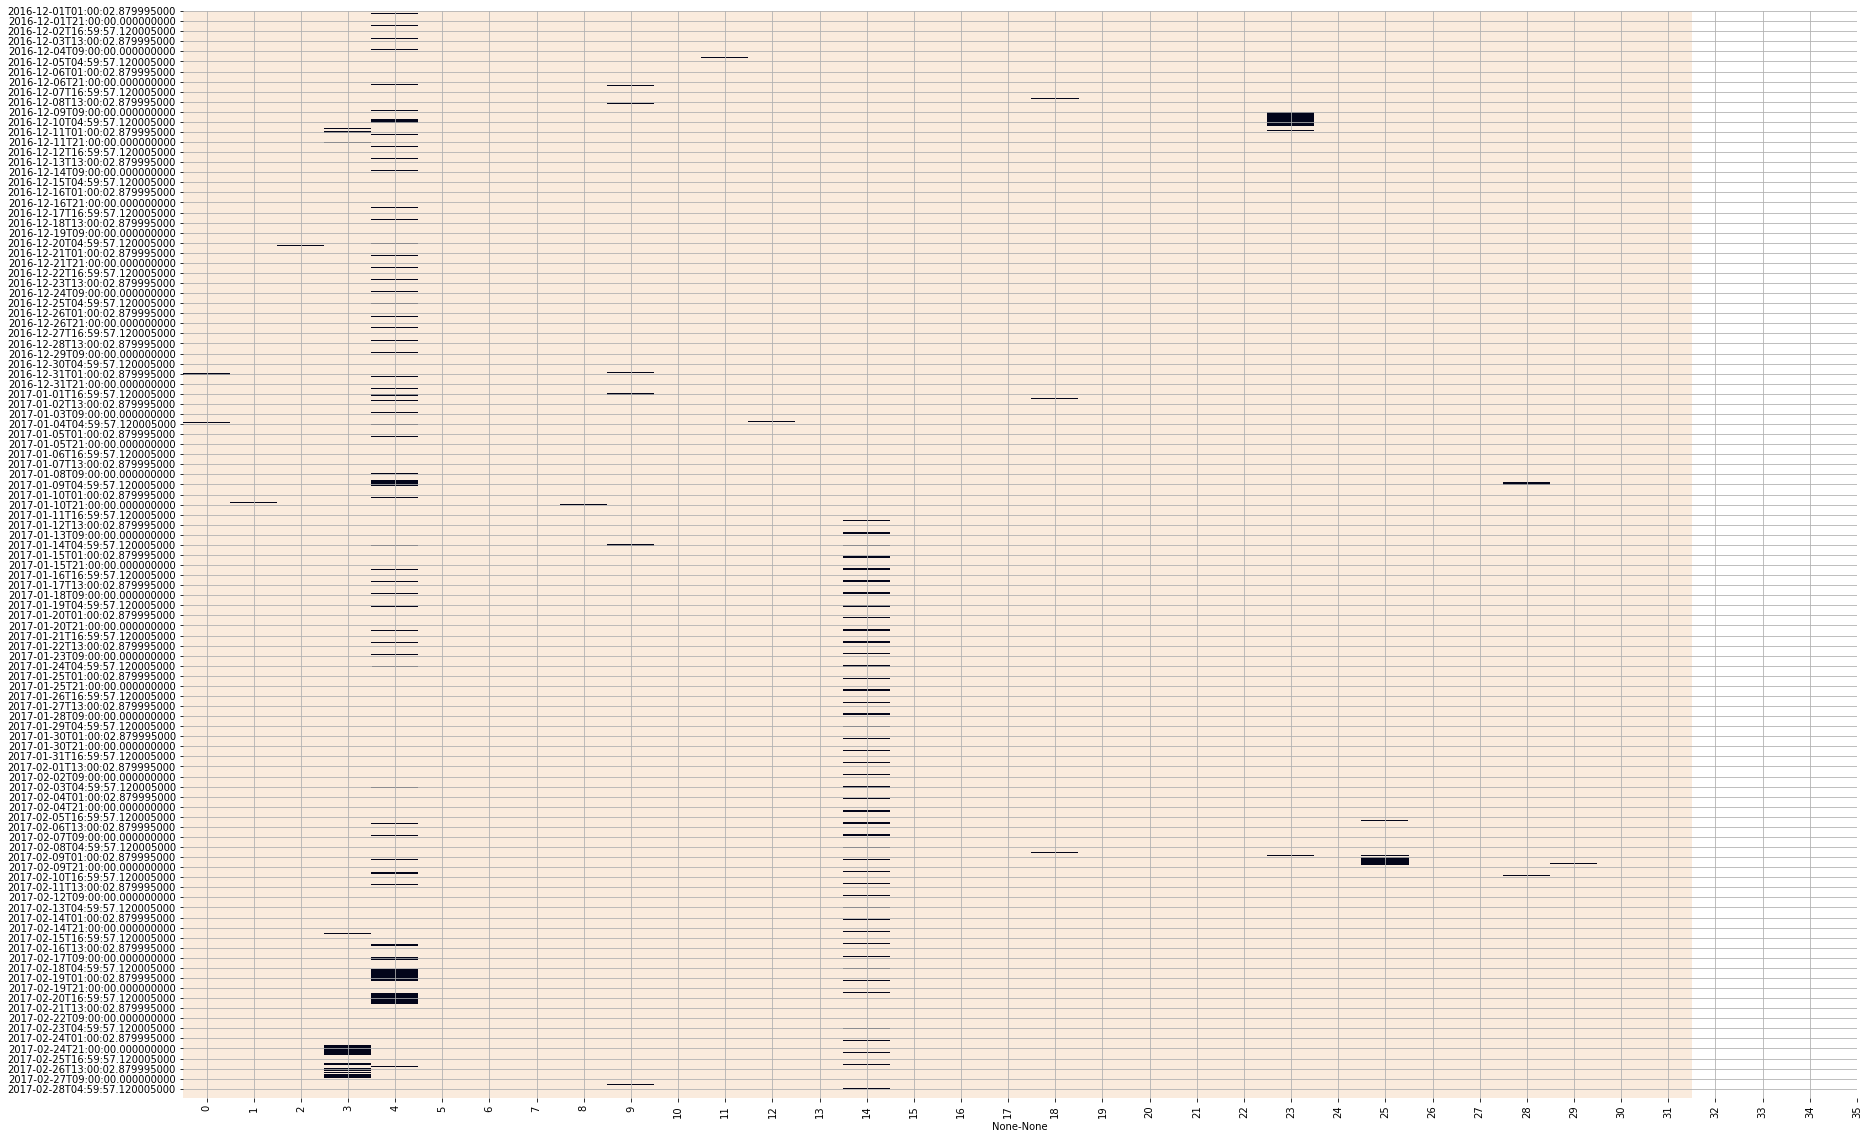

In [14]:
fig, ax = plt.subplots(figsize=(30, 20))

sns.heatmap(~winter_filt.isnull(), cbar=False, ax=ax)
ax.grid()
plt.xticks(np.arange(36)+0.5, np.arange(0, 36, 1))

plt.show()

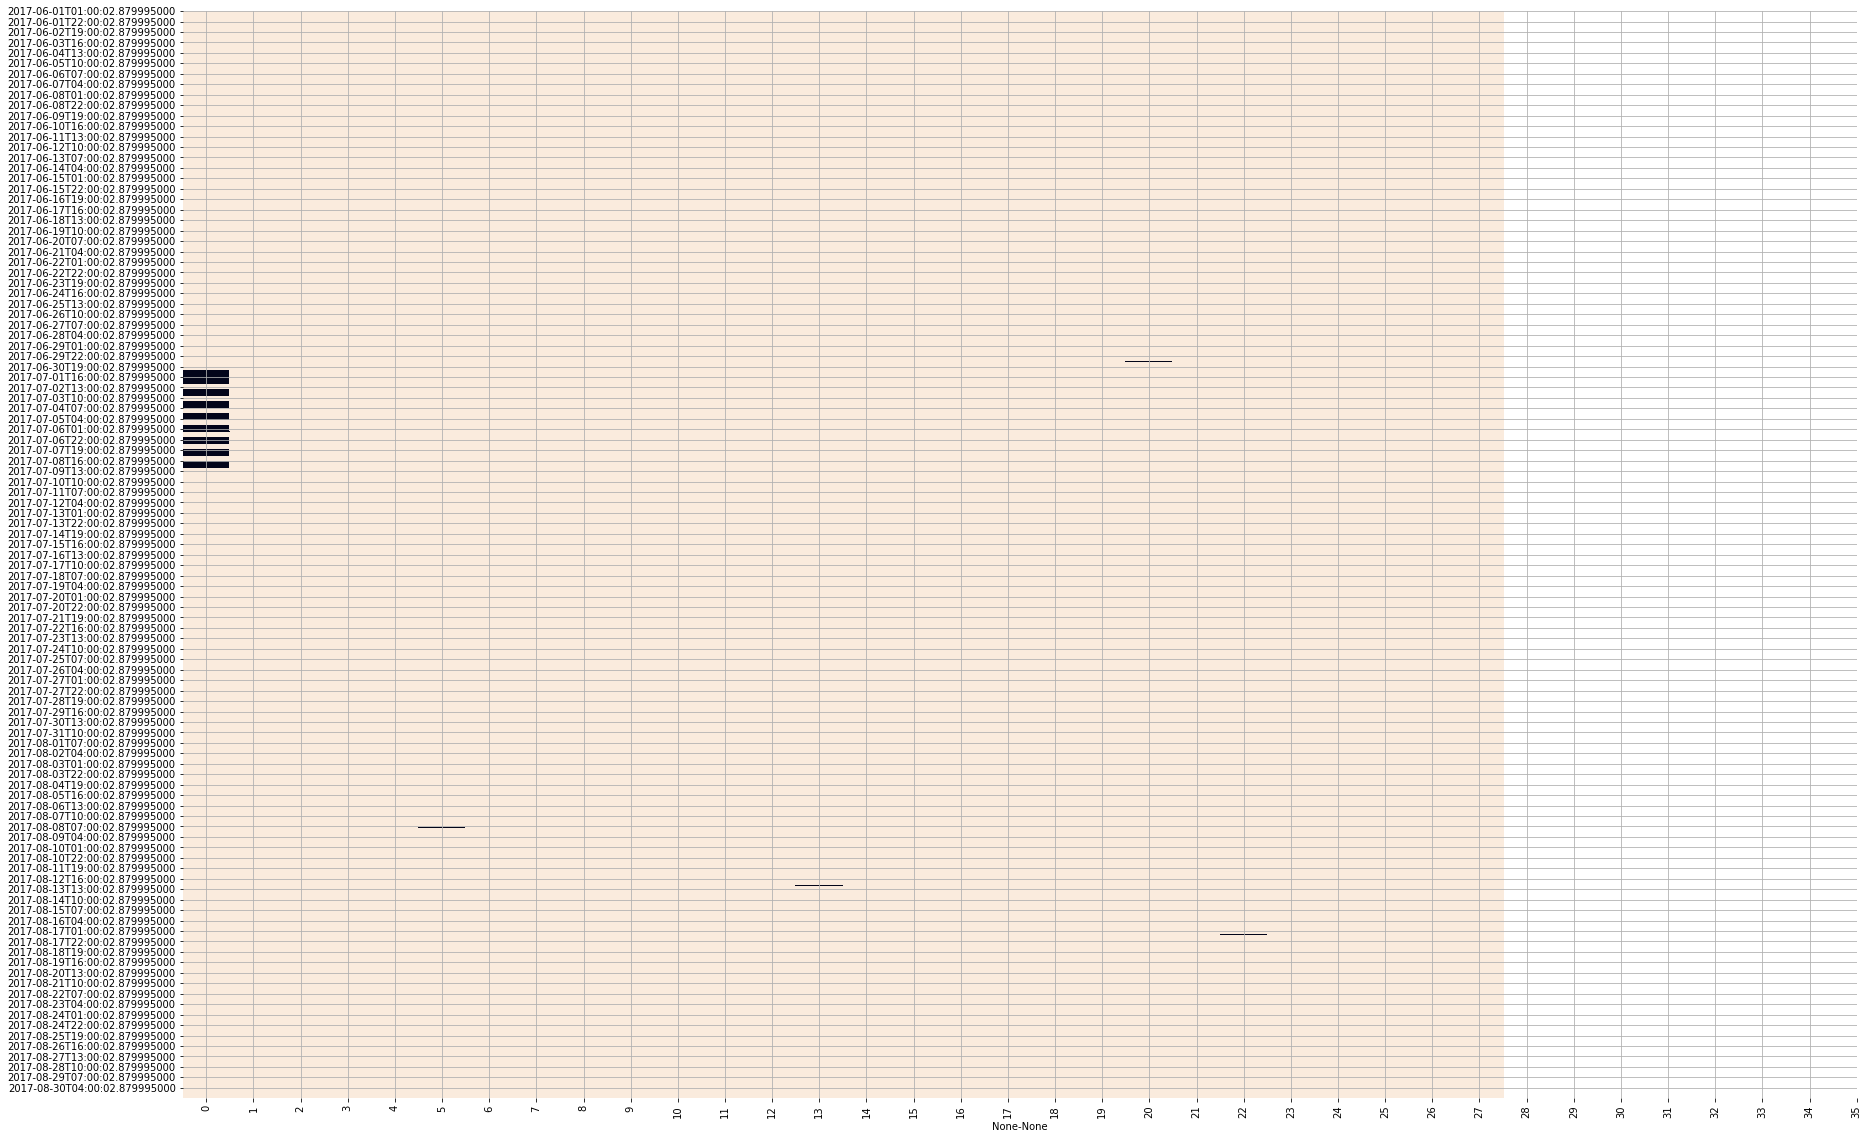

In [15]:
fig, ax = plt.subplots(figsize=(30, 20))

sns.heatmap(~summer_filt.isnull(), cbar=False, ax=ax)
ax.grid()
plt.xticks(np.arange(36)+0.5, np.arange(0, 36, 1))

plt.show()

## Now Interpolate the DataFrames

In [16]:
winter_df = winter_filt.interpolate(method='cubic', axis=0)
summer_df = summer_filt.interpolate(method='cubic', axis=0)

In [17]:
lons_and_lats = np.array(winter_df.columns)
winter_lons = np.array(list(zip(*lons_and_lats))[0])
winter_lats = np.array(list(zip(*lons_and_lats))[1])

lons_and_lats = np.array(summer_df.columns)
summer_lons = np.array(list(zip(*lons_and_lats))[0])
summer_lats = np.array(list(zip(*lons_and_lats))[1])

## Coastline Map and Island Mapping

Get the values for the coastline. The init arrays are used for when we draw a polygon over the water (otherwise we'd draw a polygon over the island).

In [18]:
coast_array = pd.read_csv('Coast.dat.txt', sep='\s+', names=['lon', 'lat'])
coast_lon_init = np.array([236, 236.8, 236.8])
coast_lat_init = np.array([48.3, 48.3, 48.999])

Get array of coastline.

In [19]:
coast_lon = coast_array['lon'].values+360
coast_lat = coast_array['lat'].values

Use to draw polygon of water

In [20]:
water_poly_lon = np.concatenate((coast_lon_init, coast_lon))
water_poly_lat = np.concatenate((coast_lat_init, coast_lat))

Lon and Lat limits for the area we are concerned with

# Look for Eigenmodes

In [21]:
interp = 'linear'
cmap = cm.magma
cmap_small = cm.bwr
vmin = -1
vmax = 1

## Winter

Create a meshgrid

In [22]:
Nx = 100
Ny = 50

xx_grid = np.linspace(min(winter_lons), max(winter_lons), Nx)
yy_grid = np.linspace(min(winter_lats), max(winter_lats), Ny)
X_grid, Y_grid = np.meshgrid(xx_grid, yy_grid)

Get covariance matrix and eigenmodes.

In [23]:
C = winter_df.cov()
eig_vals, eig_vecs = np.linalg.eigh(C)
eig_vals_norm = eig_vals/sum(eig_vals)

Create the points where the stations are and interpolate the data.

In [24]:
points = np.array(list(zip(winter_lons, winter_lats)))
winter_mode1 = eig_vecs[:,-1]
winter_mode2 = eig_vecs[:,-2]
winter_mode3 = eig_vecs[:,-3]
winter_mode4 = eig_vecs[:,-4]

winter_mode1_interp = griddata(points, winter_mode1, (X_grid, Y_grid), method=interp)
winter_mode2_interp = griddata(points, winter_mode2, (X_grid, Y_grid), method=interp)
winter_mode3_interp = griddata(points, winter_mode3, (X_grid, Y_grid), method=interp)
winter_mode4_interp = griddata(points, winter_mode4, (X_grid, Y_grid), method=interp)

Plot

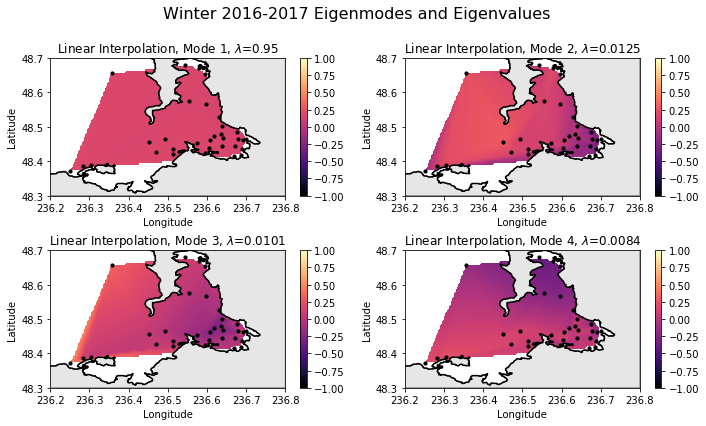

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))

cs1 = ax[0][0].contourf(X_grid, Y_grid, winter_mode1_interp, 200, cmap=cmap, vmin=vmin, vmax=vmax)
cs2 = ax[0][1].contourf(X_grid, Y_grid, winter_mode2_interp, 200, cmap=cmap, vmin=vmin, vmax=vmax)
cs3 = ax[1][0].contourf(X_grid, Y_grid, winter_mode3_interp, 200, cmap=cmap, vmin=vmin, vmax=vmax)
cs4 = ax[1][1].contourf(X_grid, Y_grid, winter_mode4_interp, 200, cmap=cmap, vmin=vmin, vmax=vmax)

[a.plot(coast_lon, coast_lat, c='k') for a in ax.ravel()]
[a.scatter(winter_lons, winter_lats, c='k', s=10) for a in ax.ravel()]

for a in ax.ravel():
    poly = Polygon(np.array([water_poly_lon, water_poly_lat]).T, facecolor='0.9', edgecolor='0.5')
    a.add_patch(poly)

[a.set_xlabel('Longitude') for a in ax.ravel()]
[a.set_ylabel('Latitude') for a in ax.ravel()]

ax[0][0].set_title('Linear Interpolation, Mode 1, $\lambda$={:.2f}'.format(eig_vals_norm[-1]))
ax[0][1].set_title('Linear Interpolation, Mode 2, $\lambda$={:.4f}'.format(eig_vals_norm[-2]))
ax[1][0].set_title('Linear Interpolation, Mode 3, $\lambda$={:.4f}'.format(eig_vals_norm[-3]))
ax[1][1].set_title('Linear Interpolation, Mode 4, $\lambda$={:.4f}'.format(eig_vals_norm[-4]))

[a.set_xlim((236.2, 236.8)) for a in ax.ravel()]
[a.set_ylim((48.3, 48.7)) for a in ax.ravel()]

# obtain colorbar
m1 = plt.cm.ScalarMappable(cmap=cmap)
m1.set_array(winter_mode1_interp)
m1.set_clim(vmin, vmax)
#set colorbars initially
cb1 = fig.colorbar(m1, ax=ax[0][0])
cb1 = fig.colorbar(m1, ax=ax[0][1])
cb1 = fig.colorbar(m1, ax=ax[1][0])
cb1 = fig.colorbar(m1, ax=ax[1][1])


fig.suptitle(r'Winter 2016-2017 Eigenmodes and Eigenvalues', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.86)

plt.show()

## Summer

Create a meshgrid.

In [26]:
Nx = 100
Ny = 50

xx_grid = np.linspace(min(summer_lons), max(summer_lons), Nx)
yy_grid = np.linspace(min(summer_lats), max(summer_lats), Ny)
X_grid, Y_grid = np.meshgrid(xx_grid, yy_grid)

Get covariance matrix and eigenmodes.

In [27]:
C = summer_df.cov()
eig_vals, eig_vecs = np.linalg.eigh(C)
eig_vals_norm = eig_vals/sum(eig_vals)

Create points where stations are and interpolate the data.

In [28]:
points = np.array(list(zip(summer_lons, summer_lats)))
summer_mode1 = eig_vecs[:,-1]
summer_mode2 = eig_vecs[:,-2]
summer_mode3 = eig_vecs[:,-3]
summer_mode4 = eig_vecs[:,-4]

summer_mode1_interp = griddata(points, summer_mode1, (X_grid, Y_grid), method=interp)
summer_mode2_interp = griddata(points, summer_mode2, (X_grid, Y_grid), method=interp)
summer_mode3_interp = griddata(points, summer_mode3, (X_grid, Y_grid), method=interp)
summer_mode4_interp = griddata(points, summer_mode4, (X_grid, Y_grid), method=interp)

Plot

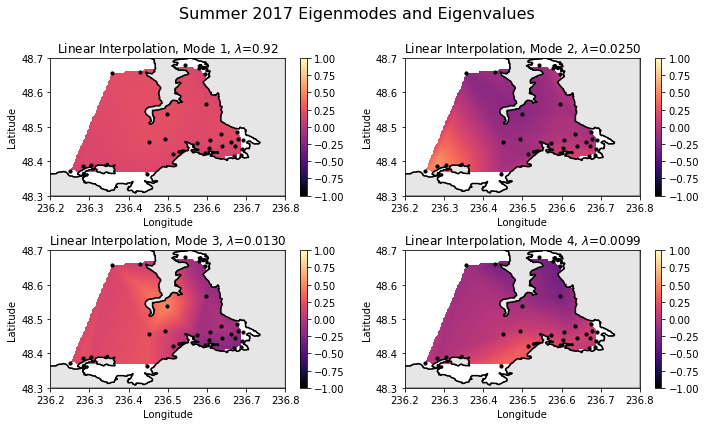

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))

cs1 = ax[0][0].contourf(X_grid, Y_grid, summer_mode1_interp, 200, cmap=cmap, vmin=vmin, vmax=vmax)
cs2 = ax[0][1].contourf(X_grid, Y_grid, summer_mode2_interp, 200, cmap=cmap, vmin=vmin, vmax=vmax)
cs3 = ax[1][0].contourf(X_grid, Y_grid, summer_mode3_interp, 200, cmap=cmap, vmin=vmin, vmax=vmax)
cs4 = ax[1][1].contourf(X_grid, Y_grid, summer_mode4_interp, 200, cmap=cmap, vmin=vmin, vmax=vmax)

[a.plot(coast_lon, coast_lat, c='k') for a in ax.ravel()]
[a.scatter(summer_lons, summer_lats, c='k', s=10) for a in ax.ravel()]

for a in ax.ravel():
    poly = Polygon(np.array([water_poly_lon, water_poly_lat]).T, facecolor='0.9', edgecolor='0.5')
    a.add_patch(poly)

[a.set_xlabel('Longitude') for a in ax.ravel()]
[a.set_ylabel('Latitude') for a in ax.ravel()]

ax[0][0].set_title('Linear Interpolation, Mode 1, $\lambda$={:.2f}'.format(eig_vals_norm[-1]))
ax[0][1].set_title('Linear Interpolation, Mode 2, $\lambda$={:.4f}'.format(eig_vals_norm[-2]))
ax[1][0].set_title('Linear Interpolation, Mode 3, $\lambda$={:.4f}'.format(eig_vals_norm[-3]))
ax[1][1].set_title('Linear Interpolation, Mode 4, $\lambda$={:.4f}'.format(eig_vals_norm[-4]))

[a.set_xlim((236.2, 236.8)) for a in ax.ravel()]
[a.set_ylim((48.3, 48.7)) for a in ax.ravel()]

# obtain colorbar
m1 = plt.cm.ScalarMappable(cmap=cmap)
m1.set_array(winter_mode1_interp)
m1.set_clim(vmin, vmax)
#set colorbars initially
cb1 = fig.colorbar(m1, ax=ax[0][0])
cb1 = fig.colorbar(m1, ax=ax[0][1])
cb1 = fig.colorbar(m1, ax=ax[1][0])
cb1 = fig.colorbar(m1, ax=ax[1][1])

fig.suptitle(r'Summer 2017 Eigenmodes and Eigenvalues', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.86)

plt.show()

# Finding Principle Components and Temperature Stuff

Our eigenvectors are known as orthogonal eigenmodes where $\vec{e}_i \cdot \vec{e}_j = \delta_{ij}$

In [53]:
print(sum(winter_mode1*winter_mode1))
print(sum(winter_mode2*winter_mode2))
print(sum(winter_mode2*winter_mode3))

1.0000000000000004
1.0000000000000004
5.898059818321144e-17


Our function can be represented as 

$$\vec{x}(t) = \sum_i \alpha_i(t) \vec{e}_i $$

where $\vec{x}$ is a vector that contains the temperature of all our stations. To find $\alpha_k(t)$ (which will be a function of time) we use

$$\vec{x}(t) \cdot \vec{e}_k =\left(\sum_i \alpha_i(t) \vec{e}_i \right) \cdot \vec{e}_k =\alpha_k(t) $$

which follows from the orthonormality above. Once we have $\alpha_k(t)$, we can plot

$$\alpha_k(t) \vec{e}_k $$

instead of just plotting $\vec{e}_k$. Since $\alpha_k(t)$ is a function of time, we may as well take the mean value (if $\alpha$ is fairly constant).

In [54]:
def get_alpha(df, mode):
    alpha = []
    for index, row in df.iterrows():
        alpha.append(sum(row.values*mode))
    
    return np.array(alpha)

## Winter

In [96]:
times_wint = np.array(winter_df.index)
b1 = get_alpha(winter_df, winter_mode1)
b2 = get_alpha(winter_df, winter_mode2)
b3 = get_alpha(winter_df, winter_mode3)
b4 = get_alpha(winter_df, winter_mode4)

## Summer

In [97]:
times_sum = np.array(summer_df.index)
a1 = get_alpha(summer_df, summer_mode1)
a2 = get_alpha(summer_df, summer_mode2)
a3 = get_alpha(summer_df, summer_mode3)
a4 = get_alpha(summer_df, summer_mode4)

Plot

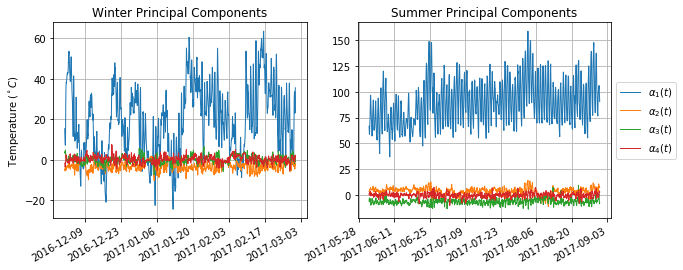

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(times_wint, b1, label=r'$\alpha_1(t)$', lw=1)
ax[0].plot(times_wint, b2, label=r'$\alpha_2(t)$', lw=1)
ax[0].plot(times_wint, b3, label=r'$\alpha_3(t)$', lw=1)
ax[0].plot(times_wint, b4, label=r'$\alpha_4(t)$', lw=1)

ax[0].set_title('Winter Principal Components')
ax[0].set_ylabel('Temperature ($^\circ C$)')
ax[0].grid()

ax[1].plot(times_sum, a1, label=r'$\alpha_1(t)$', lw=1)
ax[1].plot(times_sum, a2, label=r'$\alpha_2(t)$', lw=1)
ax[1].plot(times_sum, a3, label=r'$\alpha_3(t)$', lw=1)
ax[1].plot(times_sum, a4, label=r'$\alpha_4(t)$', lw=1)

ax[1].set_title('Summer Principal Components')
ax[1].grid()

ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.autofmt_xdate()
plt.show()

# Animation

## Summer

In [59]:
vmin_main = 5
vmax_main = 25
vmin = -5
vmax = 5

cmap = cm.magma
cmap_small = cm.bwr

In [60]:
def animate(i):

    [a.clear() for a in ax.ravel()]
    
    cs1 = ax[0][0].contourf(X_grid, Y_grid, a1[i]*summer_mode1_interp, 200, cmap=cmap, vmin=vmin_main, vmax=vmax_main)
    cs2 = ax[0][1].contourf(X_grid, Y_grid, a2[i]*summer_mode2_interp, 200, cmap=cmap_small, vmin=vmin, vmax=vmax)
    cs3 = ax[1][0].contourf(X_grid, Y_grid, a3[i]*summer_mode3_interp, 200, cmap=cmap_small, vmin=vmin, vmax=vmax)
    cs4 = ax[1][1].contourf(X_grid, Y_grid, a4[i]*summer_mode4_interp, 200, cmap=cmap_small, vmin=vmin, vmax=vmax)

    [a.plot(coast_lon, coast_lat, c='k') for a in ax.ravel()]
    [a.scatter(summer_lons, summer_lats, c='k', s=10) for a in ax.ravel()]

    for a in ax.ravel():
        poly = Polygon(np.array([water_poly_lon, water_poly_lat]).T, facecolor='0.9', edgecolor='0.5')
        a.add_patch(poly)

    ax[0][0].set_xlabel('Longitude')
    ax[0][0].set_ylabel('Latitude')

    ax[0][0].set_title('Linear Interpolation, Mode 1, $\lambda$={:.2f}'.format(eig_vals_norm[-1]))
    ax[0][1].set_title('Linear Interpolation, Mode 2, $\lambda$={:.4f}'.format(eig_vals_norm[-2]))
    ax[1][0].set_title('Linear Interpolation, Mode 3, $\lambda$={:.4f}'.format(eig_vals_norm[-3]))
    ax[1][1].set_title('Linear Interpolation, Mode 4, $\lambda$={:.4f}'.format(eig_vals_norm[-4]))

    [a.set_xlim((236.2, 236.8)) for a in ax.ravel()]
    [a.set_ylim((48.3, 48.7)) for a in ax.ravel()]

    fig.suptitle('Hour of day: {}'.format(str(summer_df.index[i].hour)), fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)

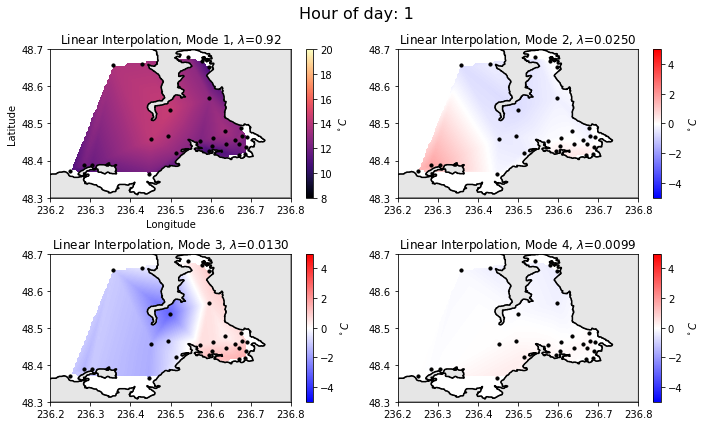

In [61]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))


cs1 = ax[0][0].contourf(X_grid, Y_grid, a1[0]*summer_mode1_interp, 200, cmap=cmap, vmin=vmin_main, vmax=vmax_main)
cs2 = ax[0][1].contourf(X_grid, Y_grid, a2[0]*summer_mode2_interp, 200, cmap=cmap_small, vmin=vmin, vmax=vmax)
cs3 = ax[1][0].contourf(X_grid, Y_grid, a3[0]*summer_mode3_interp, 200, cmap=cmap_small, vmin=vmin, vmax=vmax)
cs4 = ax[1][1].contourf(X_grid, Y_grid, a4[0]*summer_mode4_interp, 200, cmap=cmap_small, vmin=vmin, vmax=vmax)

# colorbar for mode 1
m1 = plt.cm.ScalarMappable(cmap=cmap)
m1.set_array(a1[0]*summer_mode1_interp)
m1.set_clim(8., 20.)

# colorbar for other modes
m2 = plt.cm.ScalarMappable(cmap=cmap_small)
m2.set_array(a2[0]*summer_mode2_interp)
m2.set_clim(-5., 5.)

#set colorbars initially
cb1 = fig.colorbar(m1, ax=ax[0][0], label=r'$^\circ C$')
cb2 = fig.colorbar(m2, ax=ax[0][1], label=r'$^\circ C$')
cb3 = fig.colorbar(m2, ax=ax[1][0], label=r'$^\circ C$')
cb4 = fig.colorbar(m2, ax=ax[1][1], label=r'$^\circ C$')

interval = 0.1#in seconds     
ani = animation.FuncAnimation(fig,animate,300,interval=interval*1e+3,blit=False)

In [40]:
ani.save('plots/EOF_summer_video.mp4', fps=15)

## Winter

In [48]:
vmin_main = -10
vmax_main = 15
vmin = -5
vmax = 5

cmap = cm.magma
cmap_small = cm.bwr

In [49]:
def animate(i):

    [a.clear() for a in ax.ravel()]
    
    cs1 = ax[0][0].contourf(X_grid, Y_grid, b1[i]*winter_mode1_interp, 200, cmap=cmap, vmin=vmin_main, vmax=vmax_main)
    cs2 = ax[0][1].contourf(X_grid, Y_grid, b2[i]*winter_mode2_interp, 200, cmap=cmap_small, vmin=vmin, vmax=vmax)
    cs3 = ax[1][0].contourf(X_grid, Y_grid, b3[i]*winter_mode3_interp, 200, cmap=cmap_small, vmin=vmin, vmax=vmax)
    cs4 = ax[1][1].contourf(X_grid, Y_grid, b4[i]*winter_mode4_interp, 200, cmap=cmap_small, vmin=vmin, vmax=vmax)

    [a.plot(coast_lon, coast_lat, c='k') for a in ax.ravel()]
    [a.scatter(winter_lons, winter_lats, c='k', s=10) for a in ax.ravel()]

    for a in ax.ravel():
        poly = Polygon(np.array([water_poly_lon, water_poly_lat]).T, facecolor='0.9', edgecolor='0.5')
        a.add_patch(poly)

    ax[0][0].set_xlabel('Longitude')
    ax[0][0].set_ylabel('Latitude')

    ax[0][0].set_title('Linear Interpolation, Mode 1, $\lambda$={:.2f}'.format(eig_vals_norm[-1]))
    ax[0][1].set_title('Linear Interpolation, Mode 2, $\lambda$={:.4f}'.format(eig_vals_norm[-2]))
    ax[1][0].set_title('Linear Interpolation, Mode 3, $\lambda$={:.4f}'.format(eig_vals_norm[-3]))
    ax[1][1].set_title('Linear Interpolation, Mode 4, $\lambda$={:.4f}'.format(eig_vals_norm[-4]))

    [a.set_xlim((236.2, 236.8)) for a in ax.ravel()]
    [a.set_ylim((48.3, 48.7)) for a in ax.ravel()]

    fig.suptitle('Hour of day: {}'.format(str(winter_df.index[i].hour)), fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)

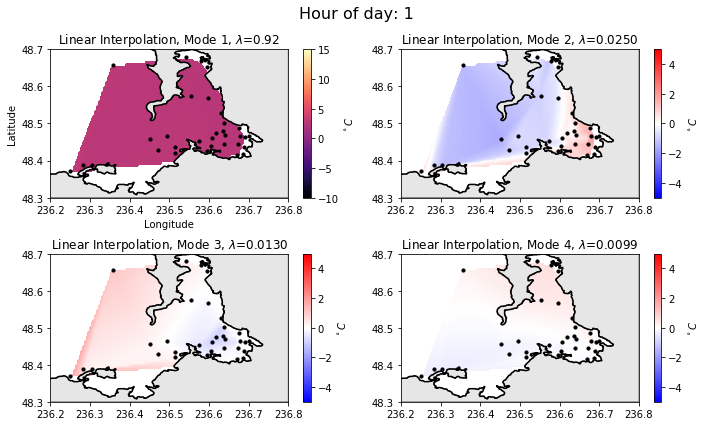

In [50]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))

cs1 = ax[0][0].contourf(X_grid, Y_grid, b1[0]*winter_mode1_interp, 200, cmap=cmap, vmin=vmin_main, vmax=vmax_main)
cs2 = ax[0][1].contourf(X_grid, Y_grid, b2[0]*winter_mode2_interp, 200, cmap=cmap_small, vmin=vmin, vmax=vmax)
cs3 = ax[1][0].contourf(X_grid, Y_grid, b3[0]*winter_mode3_interp, 200, cmap=cmap_small, vmin=vmin, vmax=vmax)
cs4 = ax[1][1].contourf(X_grid, Y_grid, b4[0]*winter_mode4_interp, 200, cmap=cmap_small, vmin=vmin, vmax=vmax)

# colorbar for mode 1
m1 = plt.cm.ScalarMappable(cmap=cmap)
m1.set_array(b1[0]*winter_mode1_interp)
m1.set_clim(-10., 15.)

# colorbar for other modes
m2 = plt.cm.ScalarMappable(cmap=cmap_small)
m2.set_array(a2[0]*winter_mode1_interp)
m2.set_clim(-5., 5.)

#set colorbars initially
cb1 = fig.colorbar(m1, ax=ax[0][0], label=r'$^\circ C$')
cb2 = fig.colorbar(m2, ax=ax[0][1], label=r'$^\circ C$')
cb3 = fig.colorbar(m2, ax=ax[1][0], label=r'$^\circ C$')
cb4 = fig.colorbar(m2, ax=ax[1][1], label=r'$^\circ C$')

interval = 0.1#in seconds     
ani = animation.FuncAnimation(fig,animate,300,interval=interval*1e+3,blit=False)

In [51]:
ani.save('plots/EOF_winter_video.mp4', fps=15)